In [2]:
from Helpers import *

In [18]:
def Linearization(dt,x):
    ts,os,taus,te,oe,taue= x[:6]
    Kfactor = 1/0.06
    C = np.array([-x[4]*(2*x[1]+x[4])*a2*np.sin(x[3]),x[1]*x[1]*a2*np.sin(x[3])])
    
    dCdte = np.array([-x[4]*(2*x[1]+x[4])*a2*np.cos(x[3]),x[1]*x[1]*a2*np.cos(x[3])])
    dCdos = np.array([-x[4]*2*a2*np.sin(x[3]),2*x[1]*a2*np.sin(x[3])])
    dCdoe = np.array([(-2*x[1]-2*x[4])*a2*np.sin(x[3]),0])
    
    
    DetM = a1*a3-a3*a3-a2*a2*cos(te)*cos(te)
    Minv = np.array([[a3,-a3-a2*cos(te)],
              [-a3-a2*cos(te),a1+2*a2*cos(te)]])/DetM
    dM = np.array([[-2*a2*sin(te),-a2*sin(te)],[-a2*sin(te),0]])
    vel = np.array([np.zeros(2),(-Minv@(dCdos+Bdyn@np.array([1,0]))),Minv@np.array([1,0]),-Minv@(dM@Minv@(np.array([taus,taue]-C-Bdyn@np.array([os,oe])))+dCdte),-Minv@(dCdoe+Bdyn@np.array([0,1])),Minv@np.array([0,1]),np.zeros(2),np.zeros(2)])
    A = np.array([[0,1,0,0,0,0,0,0],vel[:,0],[0,0,-Kfactor,0,0,0,0,0],[0,0,0,0,1,0,0,0],vel[:,1],[0,0,0,0,0,-Kfactor,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0]])
    A = np.identity(8)+dt*A
    
    return A

def myf(x):
    C = np.array([-x[4]*(2*x[1]+x[4])*a2*np.sin(x[3]),x[1]*x[1]*a2*np.sin(x[3])])
    M = np.array([[a1+2*a2*cos(x[3]),a3+a2*cos(x[3])],[a3+a2*cos(x[3]),a3]])
    print(np.linalg.solve(M,np.array([x[2],x[5]])-C-Bdyn@np.array([x[1],x[4]])))

x=np.array([pi/2,0.1,0,0.7,0,0,0,0])
Linearization(0.01,x)
myf(x)

[-0.43193287  0.72189017]


In [4]:
dt = 0.01
print(Linearization(.01,np.array([pi/4,0,0,pi/2,0,0,0,0]))-np.array([[1,dt,0,0,0,0,0,0],[0,1+dt*(-0.5*a3+0.025*a3)/((a1-a3)*a3),dt*a3/((a1-a3)*a3),0,dt*(-0.025*a3+0.5*a3)/((a1-a3)*a3),dt/(a3-a1),0,0],
     [0,0,1-dt/tau,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,dt*(0.5*a3-0.025*a1)/((a1-a3)*a3),-dt/(a1-a3),0,1+dt*(0.025*a3-0.5*a1)/(a3*(a1-a3)),a1*dt/(a3*(a1-a3)),0,0],
     [0,0,0,0,0,1-dt/tau,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]]))

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -6.93889390e-18  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.11022302e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   

In [22]:

def BestLQG(Duration = .6,w1 = 1e7,w2 = 1e7,w3 = 1e3,w4 = 1e3,r1 = 1e-5,r2 = 1e-5,targets = [0,55],starting_point = [0,20],FF = False,Side = "Right",plot = True,Delay = 0,FFonset= 0,Num_iter = 300,Activate_Noise = False,plotEstimation = False,MultipleLinearization = False,Stabilization_Time = 0):


    
    dt = Duration/Num_iter
    kdelay = int(Delay/dt)
    stab = int(Stabilization_Time/dt)
    obj1,obj2 = newton(newtonf,newtondf,1e-8,1000,targets[0],targets[1]) #Defini les targets
    st1,st2 = newton(newtonf,newtondf,1e-8,1000,starting_point[0],starting_point[1])

    xstart = np.array([st1,0,0,st2,0,0,obj1,0,obj2,0])
    x0 = np.array([st1,0,0,st2,0,0,obj1,obj2])
    x0_with_delay = np.copy(x0)
    for _ in range(kdelay):
        x0_with_delay = np.concatenate((x0_with_delay,x0))
    Num_Var = 8
    
    #Define Weight Matrices

    R = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w2,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
             [0,0,0,w3,0,0,0,-w3],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
             [-w1,0,0,0,0,0,w1,0],[0,0,0,-w3,0,0,0,w3]])
    
    
    #Define Dynamic Matrices  

    

    B_basic = np.transpose([[0,0,dt/tau,0,0,0,0,0],[0,0,0,0,0,dt/tau,0,0]])

    NewQ = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    NewQ[:Num_Var,:Num_Var] = Q 
    Q = NewQ

    H = np.zeros((Num_Var,(kdelay+1)*Num_Var))
    H[:,(kdelay)*Num_Var:]= np.identity(Num_Var)

    A = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    
    A[Num_Var:,:-Num_Var] = np.identity((kdelay)*Num_Var)
    B = np.zeros(((kdelay+1)*Num_Var,2))
    B[:Num_Var] = B_basic
    
    

    
    array_L = np.zeros((Num_iter-1,2,Num_Var*(kdelay+1)))   
    array_S = np.zeros((Num_iter,Num_Var*(kdelay+1),Num_Var*(kdelay+1))) 
    array_S[-1] = Q

        
    array_x = np.zeros((Num_iter,Num_Var))
    array_xhat = np.zeros((Num_iter,Num_Var))
    y = np.zeros((Num_iter-1,Num_Var))

    array_x[0] = x0.flatten()
    array_xhat[0] = x0.flatten()
    array_u = np.zeros((Num_iter-1,2))
    xhat = np.copy(x0_with_delay)
    x = np.copy(x0_with_delay)

    sigma = np.identity(Num_Var*(kdelay+1))*10**-6 
    J = 0
    F = [0,0]
    omega = np.zeros(2)
    for k in range(Num_iter-1):
        linpoint = x[:8] if MultipleLinearization else [pi/2,0,0,pi/4,0,0,0,0]
        A[:Num_Var,:Num_Var] = Linearization(dt,linpoint)
        if k==0:
            AKalman = np.copy(A)
        S = Q
        for l in range(Num_iter-1):
            L = np.linalg.inv(R+B.T@S@B)@B.T@S@A
            array_L[Num_iter-2-l] = L
            Qk = Q if l<stab else np.zeros(Q.shape)
            S = Qk+A.T@S@(A-B@L)
            array_S[Num_iter-2-l] = S
            
        #print(array_L[0])
        #Feedback
        L=array_L
        
        C = np.array([-x[4]*(2*x[1]+x[4])*a2*np.sin(x[3]),x[1]*x[1]*a2*np.sin(x[3])])
        
        M = np.array([[a1+2*a2*cos(x[3]),a3+a2*cos(x[3])],[a3+a2*cos(x[3]),a3]])
        #acc = np.linalg.solve(M,(np.array([x[2],x[5]])-Bdyn@np.array([x[1],x[4]])-C))+F
        acc = (np.array([array_x[k][2],array_x[k][5]])-np.array([array_x[k-1][2],array_x[k-1][5]]))/dt
        if (np.sin(x[0]+x[3])*33+np.sin(x[0])*30 > FFonset) and (FF == True):

            F = Compute_f_new_version(np.array([x[0],x[3]]),np.array([x[1],x[4]]),acc,.3)
            if Side == "Left": F*=-1

        else : 
            F = np.array([0,0])
        Omega_sens,Omega_measure,motor_noise,measure_noise = NoiseAndCovMatrix(M,Num_Var,kdelay,Linear=True)
        y[k] = (H@x).flatten()
        if Activate_Noise == True : y[k]+=measure_noise
        K = AKalman@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        sigma = Omega_sens + (AKalman - K@H)@sigma@AKalman.T
        u = - L[k].reshape(np.flip(B.shape))@xhat
        array_u[k] = u
        J+= u.T@R@u
        xhat = A@xhat + B@u + K@(y[k]-H@xhat)
        Kfactor = 1/0.06
        omega += dt*np.linalg.solve(M,np.array([x[2],x[5]])-C-Bdyn@omega)+dt*F
        x = np.concatenate((np.array([x[0]+dt*x[1],omega[0],x[2]+dt*Kfactor*(u[0]-x[2]),x[3]+dt*x[4],omega[1],x[5]+dt*Kfactor*(u[1]-x[5]),x[6],x[7]]),x[:-Num_Var]))

        if Activate_Noise : 
            x[2]+=motor_noise[0]
            x[5]+=motor_noise[1]
        array_xhat[k+1] = xhat[:Num_Var].flatten()
        array_x[k+1] = x[:Num_Var].flatten()

        #print(array_x[k-1,2],((array_x[k]-array_x[k-1])/dt)[1])   

#Plot
    J+= x.T@Q@x
    x0 = xstart
    
    x_nonlin = array_x.T[:,:][:,::1]
    X = np.cos(x_nonlin[0]+x_nonlin[3])*33+np.cos(x_nonlin[0])*30
    Y = np.sin(x_nonlin[0]+x_nonlin[3])*33+np.sin(x_nonlin[0])*30

    if plot:
        plt.plot(X,Y,color = "green",label = "LQG",linewidth = .8)
        plt.axis("equal")
        plt.scatter([targets[0]],[targets[1]],color = "black")
        if plotEstimation :
            x_nonlin = array_xhat.T[:,1:][:,::1]
            X2 = np.cos(x_nonlin[0]+x_nonlin[3])*33+np.cos(x_nonlin[0])*30
            Y2 = np.sin(x_nonlin[0]+x_nonlin[3])*33+np.sin(x_nonlin[0])*30
            plt.plot(X2,Y2,color = "black",label = "Estimation",linewidth = .8,linestyle ="--",alpha = .5)
    return X,Y,array_u,x_nonlin

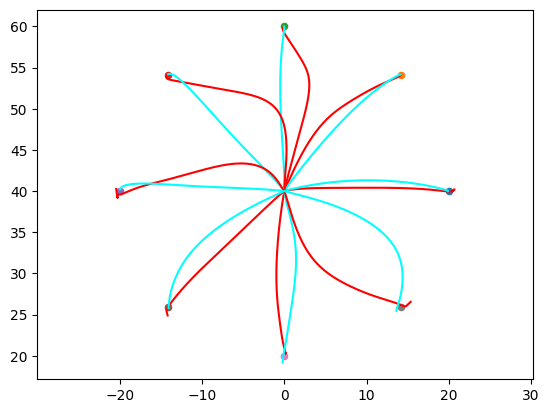

In [28]:
plt.axis("equal")
for angles in np.linspace(0,2*pi,9)[:-1] :
    tg = [cos(angles)*20,40+sin(angles)*20]
    x,y,u,z=BestLQG(Duration=.6,Num_iter=300,starting_point=[0,40],targets=tg,MultipleLinearization=True,plot = False)
    plt.plot(x,y,color = "red")
    x,y,u,z=BestLQG(Duration=.6,Num_iter=60,starting_point=[0,40],targets=tg,MultipleLinearization=False,plot = False)
    plt.plot(x,y,color = "cyan")
    plt.scatter([tg[0]],[tg[1]],s = 20)

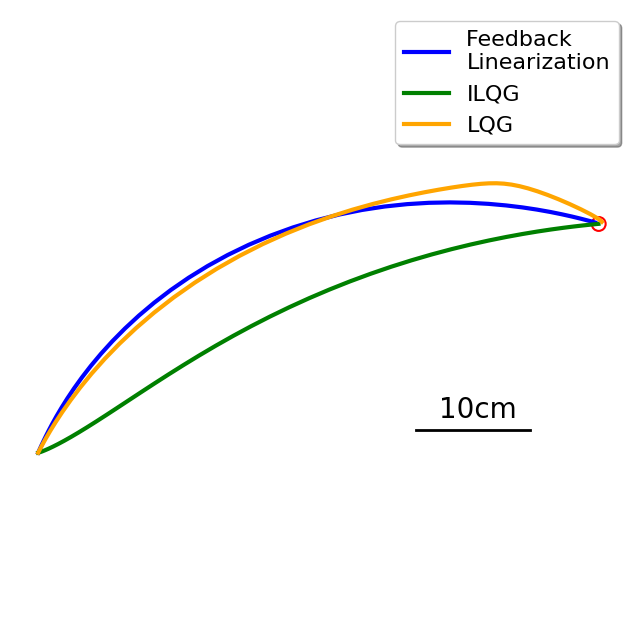

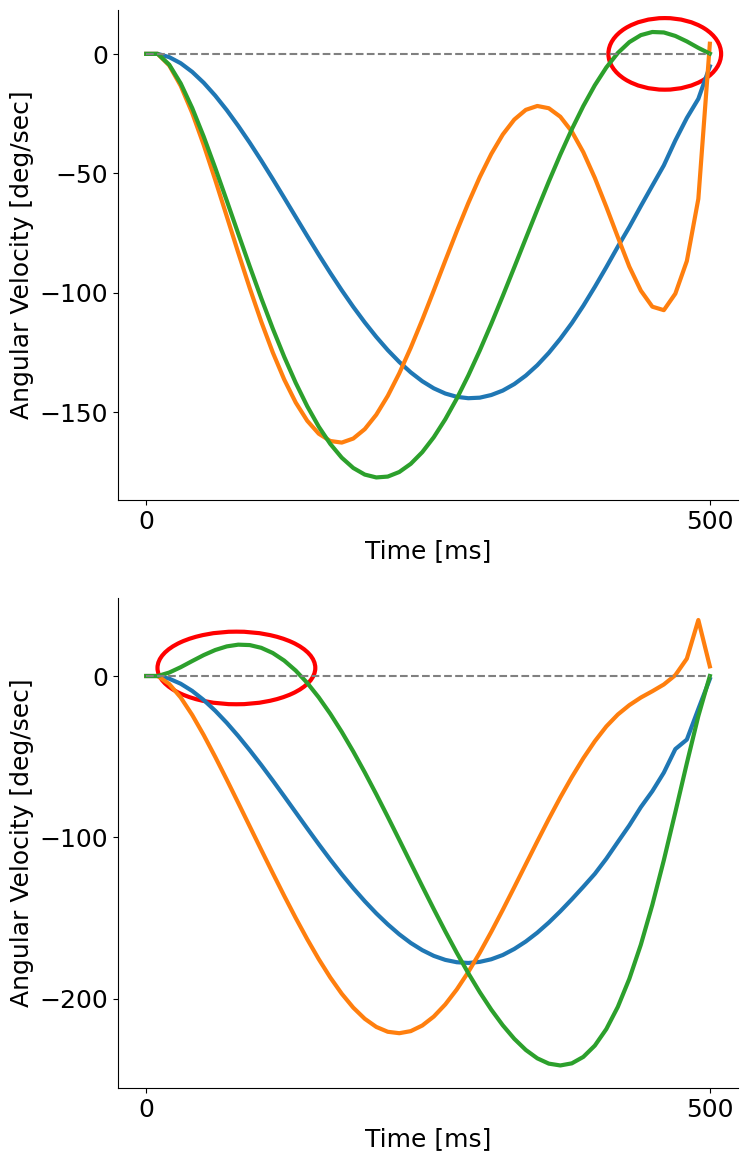

In [7]:
from ILQGController import *
from FLController import *
from matplotlib.patches import Ellipse

MovementTime = .5
NumIteration = int(MovementTime*100)
Time = np.linspace(0,MovementTime*1000,NumIteration)
plt.figure(figsize = (8,8))
xFL,yFL,j,xfl = Feedback_Linearization(Duration=MovementTime,w1=1e7,w2=1e7,w3=1e3,w4=1e3,r1=1e-5,r2=1e-5,Num_iter=NumIteration,starting_point=[-23,28],targets=[26,48],ShowJ=True,plot = False,Delay = .06,Activate_Noise=True)
xILQG,yILQG,u,zilqg=ILQG(MovementTime,1e7,1e3,1e-5,[26,48],NumIteration,[-23,28],plot = False,Delay = .06,Noise=True)
xLQG,yLQG,u,z=BestLQG(Duration=MovementTime,Num_iter=NumIteration,starting_point=[-23,28],targets=[26,48],plot = False,Delay = .06,Activate_Noise=True)
plt.plot(xFL,yFL,color = "blue",label = "Feedback \nLinearization",linewidth = 3)
plt.plot(xILQG,yILQG,color = "green",label = "ILQG",linewidth = 3)
plt.plot(xLQG,yLQG,color = "orange",label = "LQG",linewidth = 3)
plt.axis("equal")
plt.yticks([20,40,60])
plt.xticks([-20,0,20])
plt.scatter([26],[48],edgecolors='red', facecolors='none', s=100, linewidth=1.5)
ax = plt.gca()
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax.axis("off")
plt.plot([10,20],[30,30],color = "black",linewidth = 2)
plt.text(12,31,"10cm",fontsize = 20)
MultipleLabel(title="")
plt.show()

fig,ax = plt.subplots(2,figsize = (8,14))

for k in range(2):
    ax[k].spines['top'].set_visible(False)
    ax[k].spines['right'].set_visible(False)
    ax[k].tick_params(axis='both', labelsize=18)
    ax[k].set_xlabel("Time [ms]",fontsize = 18)
    ax[k].set_ylabel("Angular Velocity [deg/sec]",fontsize = 18)
ax[0].plot(Time,xfl[:,2]/pi*180,label="FL",linewidth = 3)
ax[0].plot(Time,z[1]/pi*180,label = "LQG",linewidth = 3)
ax[0].plot(Time,zilqg[:,2]/pi*180,label = "ILQG",linewidth = 3)
ax[0].plot(Time,np.zeros(len(Time)),color = "grey",linestyle = "--")
ax[0].set_yticks([0,-50,-100,-150])
ax[0].set_xticks([0,MovementTime*1000])
ax[1].set_xticks([0,MovementTime*1000])
ax[1].set_yticks([0,-100,-200])
ellipse = Ellipse(xy=(460,0), width=100, height=30, edgecolor='red', facecolor='none', linewidth=3)

# Add the ellipse to the plot
ax[0].add_patch(ellipse)



ax[1].plot(Time,xfl[:,3]/pi*180,label="FL",linewidth = 3)
ax[1].plot(Time,z[4]/pi*180,label = "LQG",linewidth = 3)
ax[1].plot(Time,zilqg[:,3]/pi*180,label = "ILQG",linewidth = 3)
ax[1].plot(Time,np.zeros(len(Time)),color = "grey",linestyle = "--")
ellipse = Ellipse(xy=(80,5), width=140, height=45, edgecolor='red', facecolor='none', linewidth=3)

# Add the ellipse to the plot
ax[1].add_patch(ellipse)
#MultipleLabel(title = "")
#x,y,u=BestLQG(Duration=.6,Num_iter=120,MultipleLinearization=True)

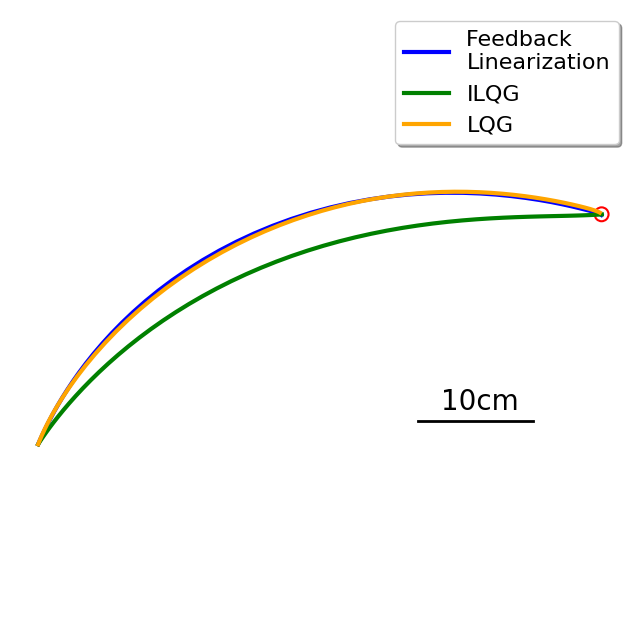

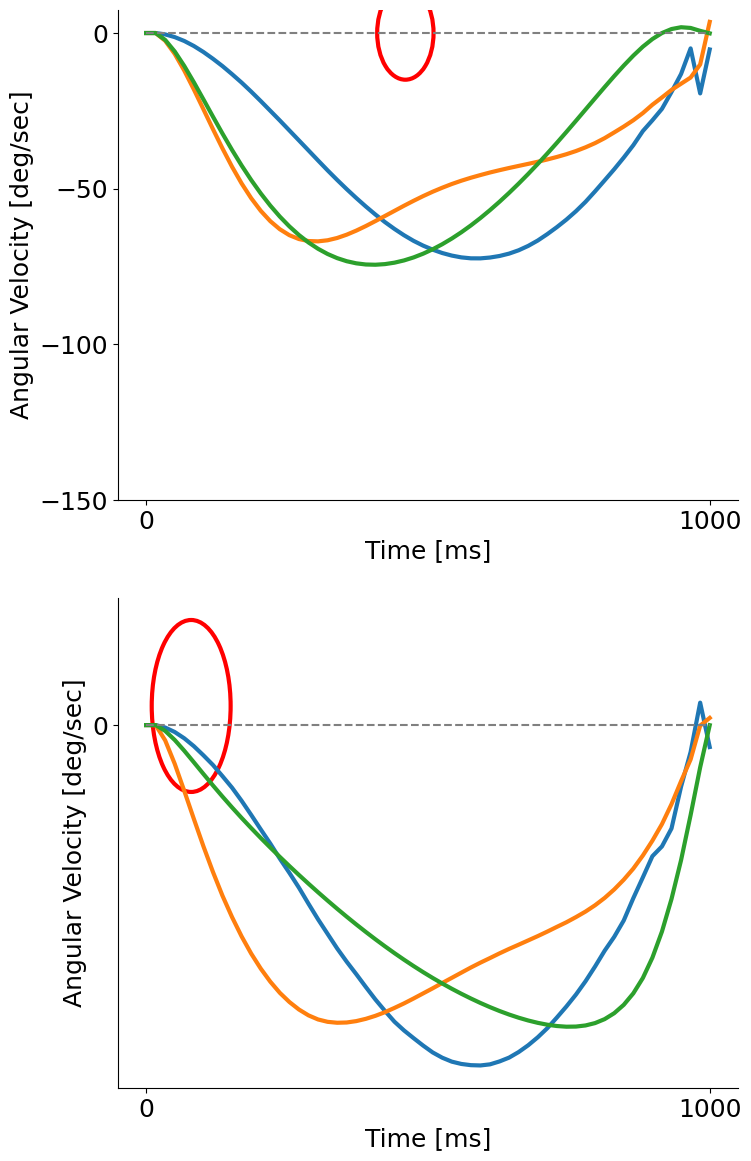

In [8]:
from ILQGController import *
from FLController import *
from matplotlib.patches import Ellipse

MovementTime = 1
NumIteration = int(MovementTime*60)
Time = np.linspace(0,MovementTime*1000,NumIteration)
plt.figure(figsize = (8,8))
xFL,yFL,j,xfl = Feedback_Linearization(Duration=MovementTime,w1=1e7,w2=1e7,w3=1e3,w4=1e3,r1=1e-5,r2=1e-5,Num_iter=NumIteration,starting_point=[-23,28],targets=[26,48],ShowJ=True,plot = False,Delay = .06,Activate_Noise=True)
xILQG,yILQG,u,zilqg=ILQG(MovementTime,1e7,1e3,1e-5,[26,48],NumIteration,[-23,28],plot = False,Delay = .06,Noise=True)
xLQG,yLQG,u,z=BestLQG(Duration=MovementTime,Num_iter=NumIteration,starting_point=[-23,28],targets=[26,48],plot = False,Delay = .06,Activate_Noise=True)
plt.plot(xFL,yFL,color = "blue",label = "Feedback \nLinearization",linewidth = 3)
plt.plot(xILQG,yILQG,color = "green",label = "ILQG",linewidth = 3)
plt.plot(xLQG,yLQG,color = "orange",label = "LQG",linewidth = 3)
plt.axis("equal")
plt.yticks([20,40,60])
plt.xticks([-20,0,20])
plt.scatter([26],[48],edgecolors='red', facecolors='none', s=100, linewidth=1.5)
ax = plt.gca()
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax.axis("off")
plt.plot([10,20],[30,30],color = "black",linewidth = 2)
plt.text(12,31,"10cm",fontsize = 20)
MultipleLabel(title="")
plt.show()

fig,ax = plt.subplots(2,figsize = (8,14))

for k in range(2):
    ax[k].spines['top'].set_visible(False)
    ax[k].spines['right'].set_visible(False)
    ax[k].tick_params(axis='both', labelsize=18)
    ax[k].set_xlabel("Time [ms]",fontsize = 18)
    ax[k].set_ylabel("Angular Velocity [deg/sec]",fontsize = 18)
ax[0].plot(Time,xfl[:,2]/pi*180,label="FL",linewidth = 3)
ax[0].plot(Time,z[1]/pi*180,label = "LQG",linewidth = 3)
ax[0].plot(Time,zilqg[:,2]/pi*180,label = "ILQG",linewidth = 3)
ax[0].plot(Time,np.zeros(len(Time)),color = "grey",linestyle = "--")
ax[0].set_yticks([0,-50,-100,-150])
ax[0].set_xticks([0,MovementTime*1000])
ax[1].set_xticks([0,MovementTime*1000])
ax[1].set_yticks([0,-100,-200])
ellipse = Ellipse(xy=(460,0), width=100, height=30, edgecolor='red', facecolor='none', linewidth=3)

# Add the ellipse to the plot
ax[0].add_patch(ellipse)



ax[1].plot(Time,xfl[:,3]/pi*180,label="FL",linewidth = 3)
ax[1].plot(Time,z[4]/pi*180,label = "LQG",linewidth = 3)
ax[1].plot(Time,zilqg[:,3]/pi*180,label = "ILQG",linewidth = 3)
ax[1].plot(Time,np.zeros(len(Time)),color = "grey",linestyle = "--")
ellipse = Ellipse(xy=(80,5), width=140, height=45, edgecolor='red', facecolor='none', linewidth=3)

# Add the ellipse to the plot
ax[1].add_patch(ellipse)

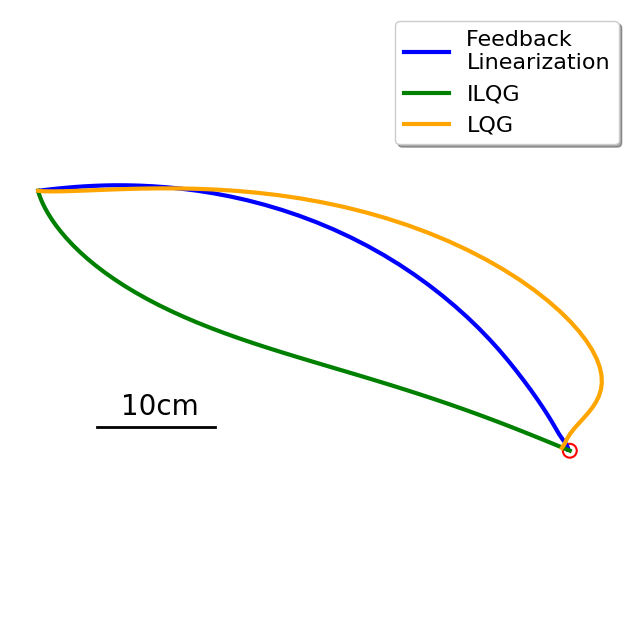

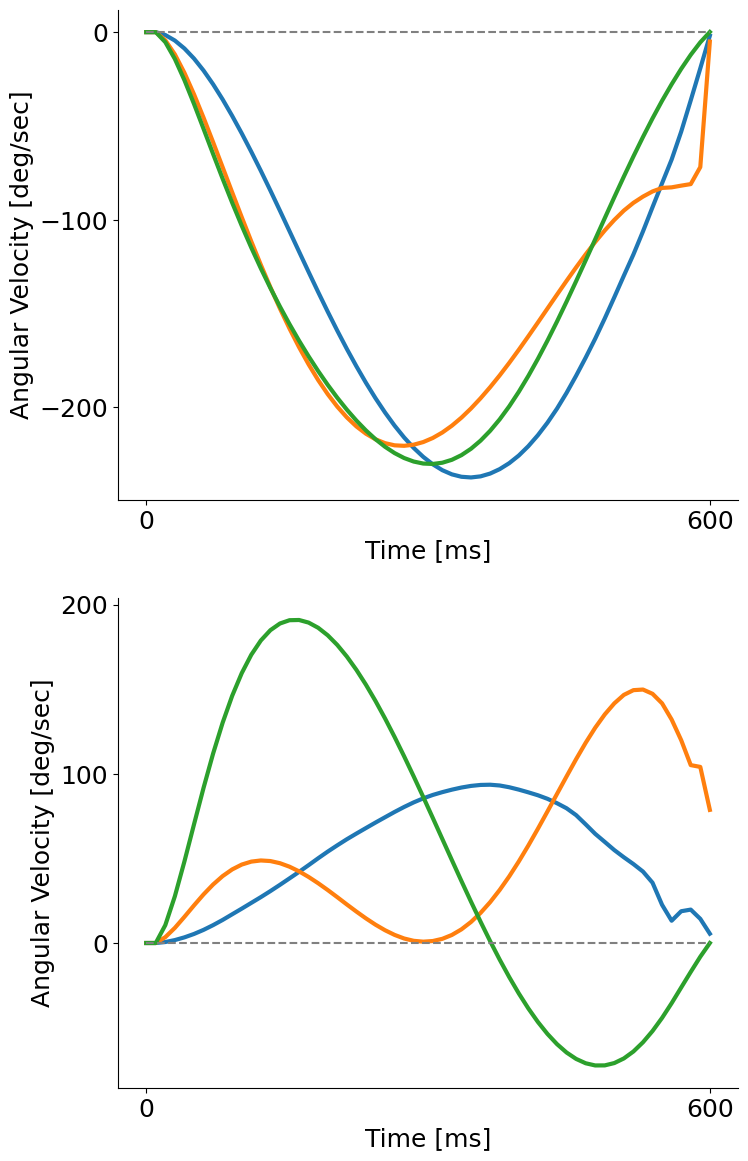

In [9]:
from ILQGController import *
from FLController import *
from matplotlib.patches import Ellipse
st = [-15,50]
tg = [30,28]
MovementTime = .6
NumIteration = int(MovementTime*100)
Time = np.linspace(0,MovementTime*1000,NumIteration)
plt.figure(figsize = (8,8))
xFL,yFL,j,xfl = Feedback_Linearization(Duration=MovementTime,w1=1e7,w2=1e7,w3=1e3,w4=1e3,r1=1e-5,r2=1e-5,Num_iter=NumIteration,starting_point=st,targets=tg,ShowJ=True,plot = False,Delay = .06,Activate_Noise=True)
xILQG,yILQG,u,zilqg=ILQG(MovementTime,1e7,1e3,1e-5,tg,NumIteration,st,plot = False,Delay = .06,Noise=True)
xLQG,yLQG,u,z=BestLQG(Duration=MovementTime,Num_iter=NumIteration,starting_point=st,targets=tg,plot = False,Delay = .06,Activate_Noise=True)
plt.plot(xFL,yFL,color = "blue",label = "Feedback \nLinearization",linewidth = 3)
plt.plot(xILQG,yILQG,color = "green",label = "ILQG",linewidth = 3)
plt.plot(xLQG,yLQG,color = "orange",label = "LQG",linewidth = 3)
plt.axis("equal")
plt.yticks([20,40,60])
plt.xticks([-20,0,20])
plt.scatter([30],[28],edgecolors='red', facecolors='none', s=100, linewidth=1.5)
ax = plt.gca()
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax.axis("off")
plt.plot([-10,0],[30,30],color = "black",linewidth = 2)
plt.text(-8,31,"10cm",fontsize = 20)
MultipleLabel(title="")
plt.show()

fig,ax = plt.subplots(2,figsize = (8,14))

for k in range(2):
    ax[k].spines['top'].set_visible(False)
    ax[k].spines['right'].set_visible(False)
    ax[k].tick_params(axis='both', labelsize=18)
    ax[k].set_xlabel("Time [ms]",fontsize = 18)
    ax[k].set_ylabel("Angular Velocity [deg/sec]",fontsize = 18)
ax[0].plot(Time,xfl[:,2]/pi*180,label="FL",linewidth = 3)
ax[0].plot(Time,z[1]/pi*180,label = "LQG",linewidth = 3)
ax[0].plot(Time,zilqg[:,2]/pi*180,label = "ILQG",linewidth = 3)
ax[0].plot(Time,np.zeros(len(Time)),color = "grey",linestyle = "--")
ax[0].set_yticks([0,-100,-200])
ax[0].set_xticks([0,MovementTime*1000])
ax[1].set_xticks([0,MovementTime*1000])
ax[1].set_yticks([0,100,200])




ax[1].plot(Time,xfl[:,3]/pi*180,label="FL",linewidth = 3)
ax[1].plot(Time,z[4]/pi*180,label = "LQG",linewidth = 3)
ax[1].plot(Time,zilqg[:,3]/pi*180,label = "ILQG",linewidth = 3)
ax[1].plot(Time,np.zeros(len(Time)),color = "grey",linestyle = "--")
#MultipleLabel(title = "")

In [10]:
from ILQGController import *
from FLController import *
from matplotlib.patches import Ellipse
st = [-15,50]
tg = [30,28]
plt.figure(figsize = (8,8))
for stabilization in [0,.2]:
    MovementTime = .6+stabilization
    NumIteration = 120
    Time = np.linspace(0,MovementTime*1000,NumIteration)
    xFL,yFL,j,xfl = Feedback_Linearization(Duration=MovementTime,w1=1e4,w2=1e4,w3=1e1,w4=1e1,r1=1e-5,r2=1e-5,Num_iter=NumIteration,starting_point=st,targets=tg,ShowJ=True,plot = False,Delay = .06,Activate_Noise=True,Stabilization_Time=stabilization)
    xILQG,yILQG,u,zilqg=ILQG(MovementTime,1e4,1e1,1e-5,tg,NumIteration,st,plot = False,Delay = .06,Noise=True,Stabilization_Time=stabilization)
    xLQG,yLQG,u,z=BestLQG(Duration=MovementTime,w1=1e4,w2=1e4,w3=1e1,w4=1e1,Num_iter=NumIteration,starting_point=st,targets=tg,plot = False,Delay = .06,Activate_Noise=True,Stabilization_Time=stabilization)
    plt.plot(xFL,yFL,color = "blue",label = "Feedback \nLinearization",linewidth = 3)
    plt.plot(xILQG,yILQG,color = "green",label = "ILQG",linewidth = 3)
    plt.plot(xLQG,yLQG,color = "orange",label = "LQG",linewidth = 3)
    plt.axis("equal")
    plt.yticks([20,40,60])
    plt.xticks([-20,0,20])
    plt.scatter([30],[28],edgecolors='red', facecolors='none', s=100, linewidth=1.5)
    ax = plt.gca()
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    ax.axis("off")
    plt.plot([-10,0],[30,30],color = "black",linewidth = 2)
    plt.text(-8,31,"10cm",fontsize = 20)
MultipleLabel(title="")

fig,ax = plt.subplots(2,figsize = (8,14))

for k in range(2):
    ax[k].spines['top'].set_visible(False)
    ax[k].spines['right'].set_visible(False)
    ax[k].tick_params(axis='both', labelsize=18)
    ax[k].set_xlabel("Time [ms]",fontsize = 18)
    ax[k].set_ylabel("Angular Velocity [deg/sec]",fontsize = 18)
ax[0].plot(Time,xfl[:,2]/pi*180,label="FL",linewidth = 3)
ax[0].plot(Time,z[1]/pi*180,label = "LQG",linewidth = 3)
ax[0].plot(Time,zilqg[:,2]/pi*180,label = "ILQG",linewidth = 3)
ax[0].plot(Time,np.zeros(len(Time)),color = "grey",linestyle = "--")
ax[0].set_yticks([0,-100,-200])
ax[0].set_xticks([0,MovementTime*1000])
ax[1].set_xticks([0,MovementTime*1000])
ax[1].set_yticks([0,100,200])




ax[1].plot(Time,xfl[:,3]/pi*180,label="FL",linewidth = 3)
ax[1].plot(Time,z[4]/pi*180,label = "LQG",linewidth = 3)
ax[1].plot(Time,zilqg[:,3]/pi*180,label = "ILQG",linewidth = 3)
ax[1].plot(Time,np.zeros(len(Time)),color = "grey",linestyle = "--")

TypeError: ILQG() got an unexpected keyword argument 'Stabilization_Time'

<Figure size 800x800 with 0 Axes>

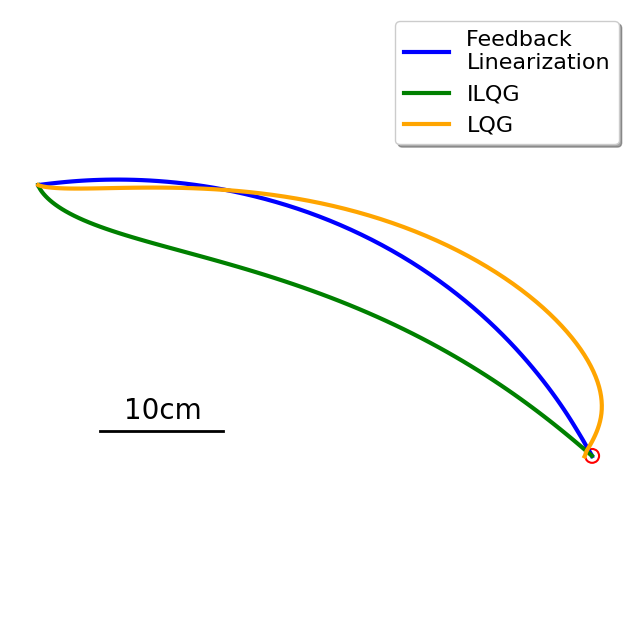

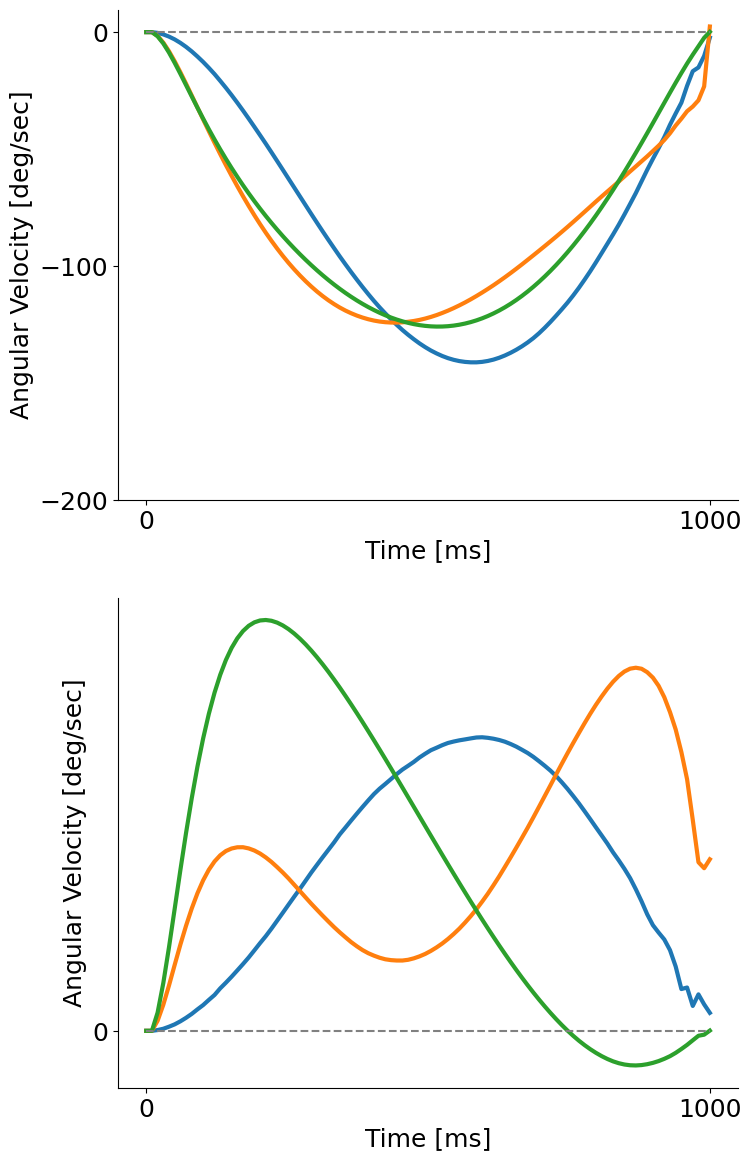

In [10]:
from ILQGController import *
from FLController import *
from matplotlib.patches import Ellipse
st = [-15,50]
tg = [30,28]
MovementTime = 1
NumIteration = int(MovementTime*100)
Time = np.linspace(0,MovementTime*1000,NumIteration)
plt.figure(figsize = (8,8))
xFL,yFL,j,xfl = Feedback_Linearization(Duration=MovementTime,w1=1e7,w2=1e7,w3=1e3,w4=1e3,r1=1e-5,r2=1e-5,Num_iter=NumIteration,starting_point=st,targets=tg,ShowJ=True,plot = False,Delay = .06,Activate_Noise=True)
xILQG,yILQG,u,zilqg=ILQG(MovementTime,1e7,1e3,1e-5,tg,NumIteration,st,plot = False,Delay = .06,Noise=True)
xLQG,yLQG,u,z=BestLQG(Duration=MovementTime,Num_iter=NumIteration,starting_point=st,targets=tg,plot = False,Delay = .06,Activate_Noise=True)
plt.plot(xFL,yFL,color = "blue",label = "Feedback \nLinearization",linewidth = 3)
plt.plot(xILQG,yILQG,color = "green",label = "ILQG",linewidth = 3)
plt.plot(xLQG,yLQG,color = "orange",label = "LQG",linewidth = 3)
plt.axis("equal")
plt.yticks([20,40,60])
plt.xticks([-20,0,20])
plt.scatter([30],[28],edgecolors='red', facecolors='none', s=100, linewidth=1.5)
ax = plt.gca()
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax.axis("off")
plt.plot([-10,0],[30,30],color = "black",linewidth = 2)
plt.text(-8,31,"10cm",fontsize = 20)
MultipleLabel(title="")
plt.show()

fig,ax = plt.subplots(2,figsize = (8,14))

for k in range(2):
    ax[k].spines['top'].set_visible(False)
    ax[k].spines['right'].set_visible(False)
    ax[k].tick_params(axis='both', labelsize=18)
    ax[k].set_xlabel("Time [ms]",fontsize = 18)
    ax[k].set_ylabel("Angular Velocity [deg/sec]",fontsize = 18)
ax[0].plot(Time,xfl[:,2]/pi*180,label="FL",linewidth = 3)
ax[0].plot(Time,z[1]/pi*180,label = "LQG",linewidth = 3)
ax[0].plot(Time,zilqg[:,2]/pi*180,label = "ILQG",linewidth = 3)
ax[0].plot(Time,np.zeros(len(Time)),color = "grey",linestyle = "--")
ax[0].set_yticks([0,-100,-200])
ax[0].set_xticks([0,MovementTime*1000])
ax[1].set_xticks([0,MovementTime*1000])
ax[1].set_yticks([0,100,200])




ax[1].plot(Time,xfl[:,3]/pi*180,label="FL",linewidth = 3)
ax[1].plot(Time,z[4]/pi*180,label = "LQG",linewidth = 3)
ax[1].plot(Time,zilqg[:,3]/pi*180,label = "ILQG",linewidth = 3)
ax[1].plot(Time,np.zeros(len(Time)),color = "grey",linestyle = "--")

(50, 6)


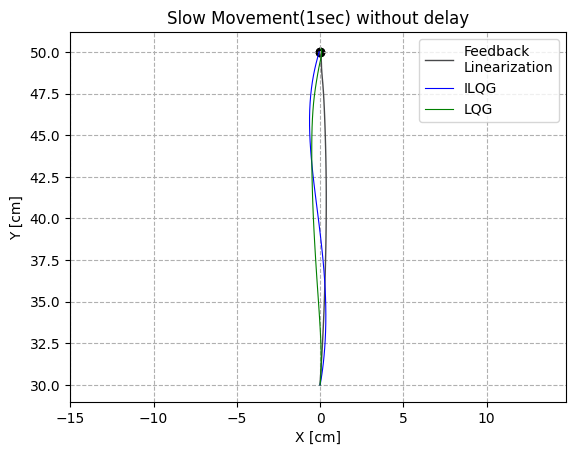

(50, 6)


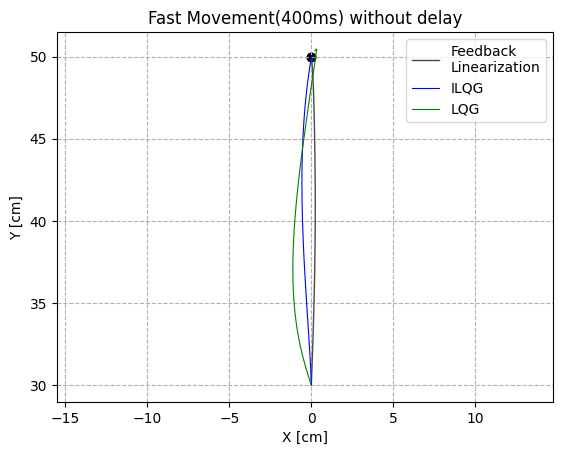

(50, 24)


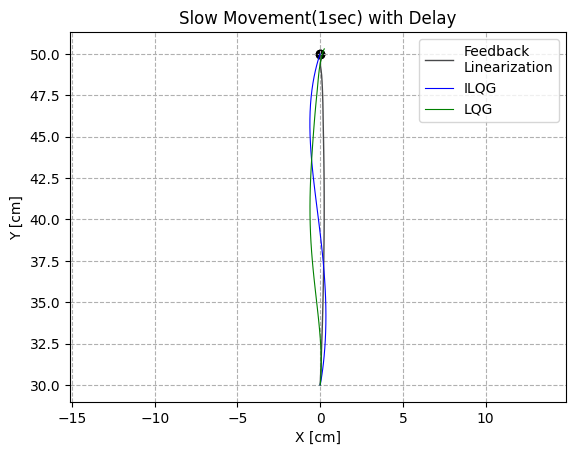

(50, 48)


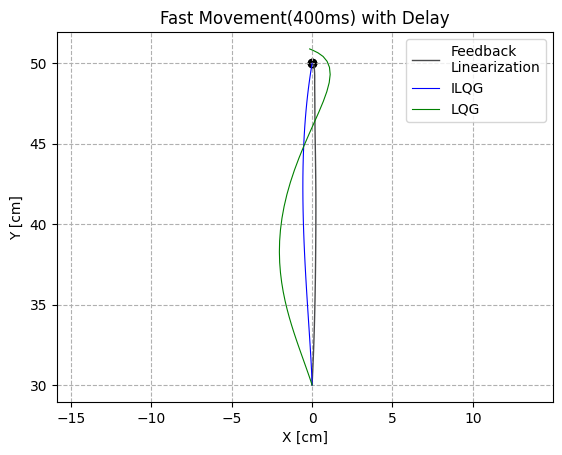

In [11]:
from ILQGController import *
from FLController import *
for Delay in [0,0.06]:
    for Duration in [1,.4]:
        x,y,j,xfl = Feedback_Linearization(Duration=Duration,w1=1e7,w2=1e7,w3=1e3,w4=1e3,r1=1e-5,r2=1e-5,Num_iter=50,starting_point=[0,30],targets=[0,50],ShowJ=True,Activate_Noise=True,Delay=Delay)
        x,y,u,zilqg=ILQG(Duration,1e7,1e3,1e-5,[0,50],50,[0,30],Noise=True,Delay=Delay)
        print(zilqg.shape)
        x,y,u,z=BestLQG(Duration=Duration,Num_iter=50,starting_point=[0,30],targets=[0,50],Activate_Noise=True,Delay=Delay)
        plt.legend()
        title1 = "Slow Movement(1sec)" if Duration == 1 else "Fast Movement(400ms)"
        title2 = " without delay" if Delay == 0 else " with Delay"
        plt.title(title1+title2)
        plt.show()
    #x,y,u=BestLQG(Duration=.6,Num_iter=120,MultipleLinearization=True)

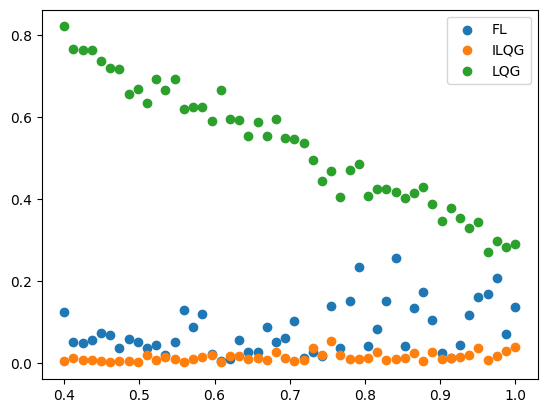

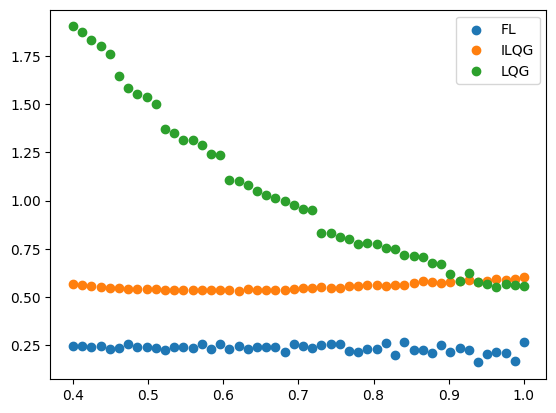

In [12]:
from ILQGController import *
from FLController import *

Delay = .06
Error = np.zeros((6,50))
D = np.linspace(0.4,1,50)
for i,Duration in enumerate(D):
        x,y,j,xfl = Feedback_Linearization(Duration=Duration,w1=1e7,w2=1e7,w3=1e3,w4=1e3,r1=1e-5,r2=1e-5,Num_iter=60,starting_point=[0,30],targets=[0,50],ShowJ=True,Activate_Noise=True,Delay=Delay,plot = False)
        Error[0,i] = np.sqrt((x[-1])**2+(y[-1]-50)**2)
        Error[3,i] = np.max(np.abs(x))
        x,y,u,zilqg=ILQG(Duration,1e7,1e3,1e-5,[0,50],60,[0,30],Noise=True,Delay=Delay,plot = False)
        Error[1,i] = np.sqrt((x[-1])**2+(y[-1]-50)**2)
        Error[4,i] = np.max(np.abs(x))
        x,y,u,z=BestLQG(Duration=Duration,Num_iter=60,starting_point=[0,30],targets=[0,50],Activate_Noise=True,Delay=Delay,plot = False)
        Error[2,i] = np.sqrt((x[-1])**2+(y[-1]-50)**2)
        Error[5,i] = np.max(np.abs(x))

LABELS = ["FL","ILQG","LQG"]
for i in range(3):
        plt.scatter(D,Error[i],label = LABELS[i])
plt.legend()
plt.show()

for i in range(3,6):
        plt.scatter(D,Error[i],label = LABELS[i-3])
plt.legend()
plt.show()

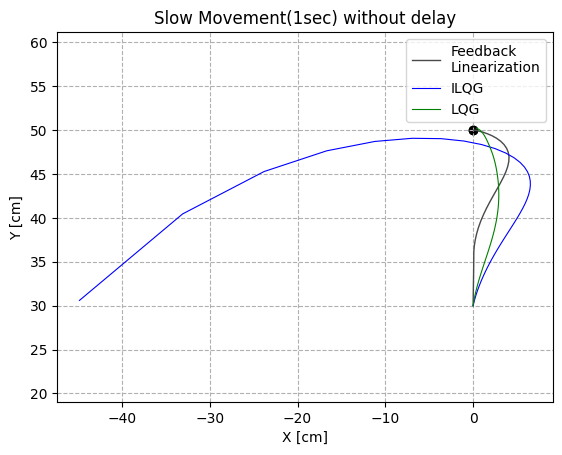

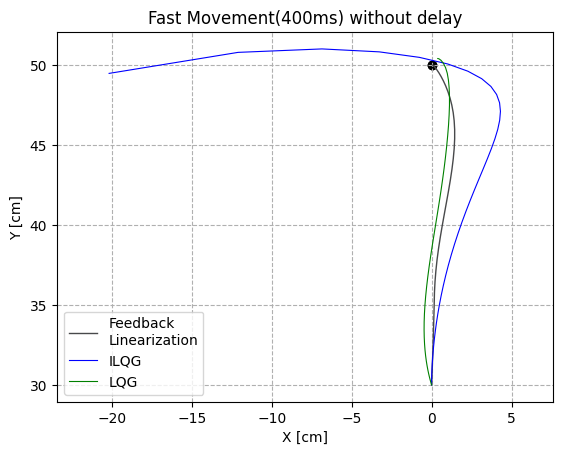

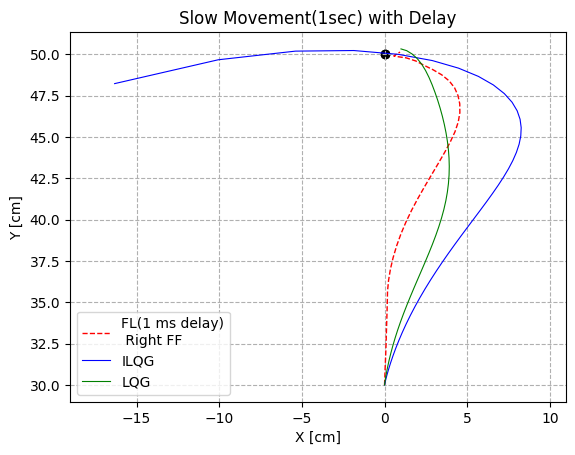

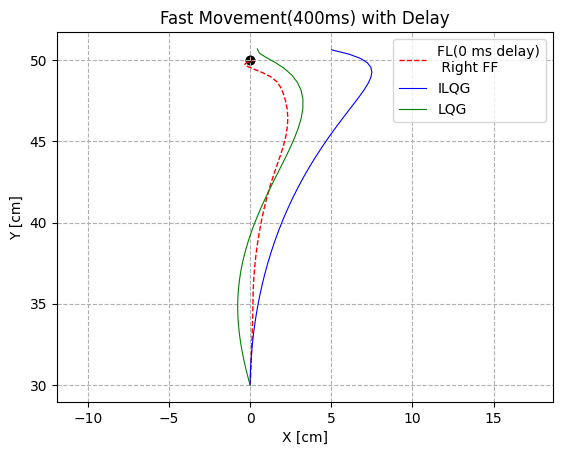

In [13]:
from ILQGController import *
from FLController import *
for Delay in [0,0.06]:
    for Duration in [1,.4]:
        x,y,j,xfl = Feedback_Linearization(Duration=Duration,w1=1e7,w2=1e7,w3=1e3,w4=1e3,r1=1e-5,r2=1e-5,Num_iter=50,starting_point=[0,30],targets=[0,50],ShowJ=True,Activate_Noise=True,Delay=Delay,AdditionalDynamics={"FF":True,"FFonset":35,"Side":"Right"})
        x,y,u,zilqg=ILQG(Duration,1e7,1e3,1e-5,[0,50],50,[0,30],Noise=True,Delay=Delay,FF=True,Side="Right")
        x,y,u,z=BestLQG(Duration=Duration,Num_iter=50,starting_point=[0,30],targets=[0,50],Activate_Noise=True,Delay=Delay,FF=True)
        plt.legend()
        title1 = "Slow Movement(1sec)" if Duration == 1 else "Fast Movement(400ms)"
        title2 = " without delay" if Delay == 0 else " with Delay"
        plt.title(title1+title2)
        plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Create a simple plot
fig, ax = plt.subplots()

# Plot an arrow going to the right
ax.annotate('', xy=(3, 0), xytext=(1, 0),
            arrowprops=dict(facecolor='blue', edgecolor='blue', arrowstyle="->", lw=2))

# Add the text above the arrow using LaTeX formatting
ax.text(1.5, 0.1, r'$F_x = k\dot{y}$', fontsize=14, ha='center')

# Set limits and labels to make the plot clear
ax.set_xlim(-1, 4)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')

# Show the plot
plt.show()

ImportError: Failed to import any of the following Qt binding modules: PyQt6, PySide6, PyQt5, PySide2

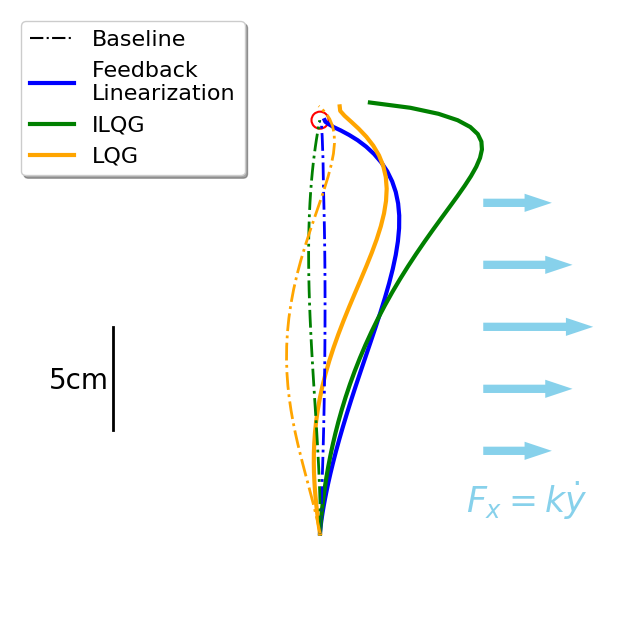

In [15]:
from ILQGController import *
from FLController import *
from matplotlib.patches import Ellipse
from matplotlib.patches import FancyArrow
st = [0,30]
tg = [0,50]
MovementTime = .5
NumIteration = int(MovementTime*100)
Time = np.linspace(0,MovementTime*1000,NumIteration)
side = "Right"
plt.figure(figsize = (8,8))
lw = [3,2]
ls = ["-","-."]
plt.plot([0,0],[30,30],color = "black",linestyle = "-.",label = "Baseline")
for i,activation in enumerate([True,False]):
    xFL,yFL,j,xfl = Feedback_Linearization(Duration=MovementTime,w1=1e7,w2=1e7,w3=1e3,w4=1e3,r1=1e-5,r2=1e-5,Num_iter=NumIteration,starting_point=st,targets=tg,ShowJ=True,plot = False,AdditionalDynamics={"FF":activation,"FFonset":30,"Side":side},Delay = .06,Activate_Noise=True)
    xILQG,yILQG,u,zilqg=ILQG(MovementTime,1e7,1e3,1e-5,tg,NumIteration,st,plot = False,Delay = .06,Noise=True,FF=activation,Side=side)
    xLQG,yLQG,u,z=BestLQG(Duration=MovementTime,Num_iter=NumIteration,starting_point=st,targets=tg,plot = False,Delay = .06,Activate_Noise=True,FF=activation,Side=side)
    plt.plot(xFL,yFL,color = "blue",label = "Feedback \nLinearization",linewidth = lw[i],linestyle = ls[i])
    plt.plot(xILQG,yILQG,color = "green",label = "ILQG",linewidth = lw[i],linestyle = ls[i])
    plt.plot(xLQG,yLQG,color = "orange",label = "LQG",linewidth = lw[i],linestyle = ls[i])
    
    if i == 0: MultipleLabel(title="",side="left")
plt.axis("equal")
plt.yticks([30,40,50])
plt.xticks([-10,0,10])
plt.xlim(-15,15)
plt.scatter([tg[0]],[tg[1]],edgecolors='red', facecolors='none', s=150, linewidth=1.5)
ax = plt.gca()
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax.axis("off")
plt.plot([-10,-10],[35,40],color = "black",linewidth = 2)
plt.text(-13.1,37,"5cm",fontsize = 20)

Y = [35,38,41,44,47]
DY = [2,3,4,3,2]
mycolor = "#87d1eb"
for i in range(5):
    arrow = FancyArrow(x=8, y=Y[i]-1, dx=DY[i], dy=0, width=0.2, edgecolor=mycolor, facecolor=mycolor, linewidth=3)
    ax.add_patch(arrow)
# Add the arrow to the plot



# Add the text above the arrow using LaTeX formatting
ax.text(10,31, r'$F_x = k\dot{y}$', fontsize=25, ha='center',color = mycolor, fontweight='bold')
plt.show()


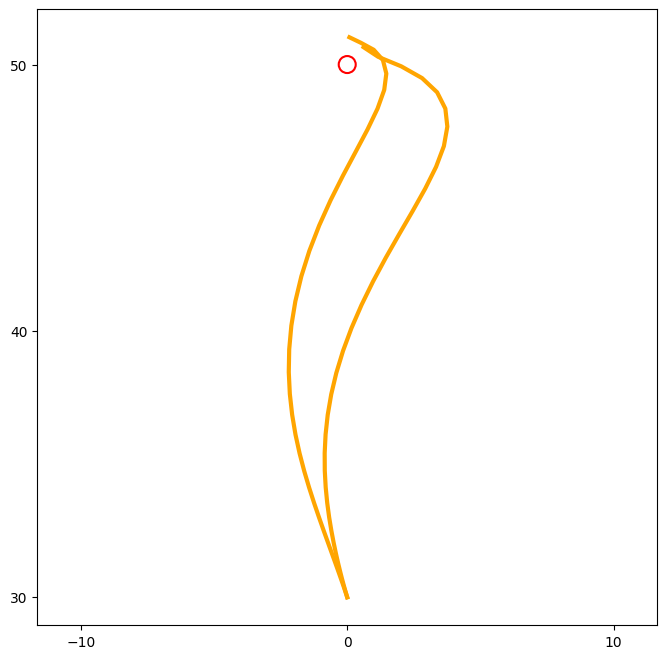

In [16]:
st = [0,30]
tg = [0,50]
MovementTime = .4
NumIteration = int(MovementTime*100)
Time = np.linspace(0,MovementTime*1000,NumIteration)
side = "Right"
plt.figure(figsize = (8,8))
xLQG,yLQG,u,z=BestLQG(Duration=MovementTime,Num_iter=NumIteration,starting_point=st,targets=tg,plot = False,Delay = .06,Activate_Noise=True,FF=True,Side=side)
plt.plot(xLQG,yLQG,color = "orange",label = "LQG",linewidth = 3)
xLQG,yLQG,u,z=BestLQG(Duration=MovementTime,Num_iter=NumIteration,starting_point=st,targets=tg,plot = False,Delay = .06,Activate_Noise=True,FF=False,Side=side)
plt.plot(xLQG,yLQG,color = "orange",label = "LQG",linewidth = 3)
plt.axis("equal")
plt.yticks([30,40,50])
plt.xticks([-10,0,10])
plt.xlim(-15,15)
plt.scatter([tg[0]],[tg[1]],edgecolors='red', facecolors='none', s=150, linewidth=1.5)
ax = plt.gca()